In [1]:
from normalize_data import getNormalizedDataset
import pandas as pd

In [2]:
df_train = getNormalizedDataset()
df_test = pd.read_csv('test.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
pd.set_option('display.float_format', '{:.2f}'.format)

(230396, 18)
(230060, 18)
(230041, 18)
(220417, 19)


In [3]:
df_train.columns

Index(['titulo', 'descripcion', 'tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio', 'precio_m2',
       'precio_dolar', 'extras'],
      dtype='object')

# Preprocesamiento

In [4]:
# Saco titulo, descripcion, precio_m2, precio_dolar, extras
df_train = df_train[['tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio']]

df_train['dia'] = df_train.fecha.dt.day
df_train['mes'] = df_train.fecha.dt.month
df_train['año'] = df_train.fecha.dt.year

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
# Label encoding
cat_features = ['tipodepropiedad', 'ciudad', 'provincia']
encoder = LabelEncoder()
encoded = df_train[cat_features].apply(encoder.fit_transform)

data_cols = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio', 'dia', 'mes', 'año']
baseline_data = df_train[data_cols].join(encoded)

In [7]:
baseline_data.head()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,dia,mes,año,tipodepropiedad,ciudad,provincia
id,,,,,,,,,,,,,,,,,,
254099,nan,2.00,1.00,2.00,80.00,80.00,0,0,0,0,0,2273000.00,23,8,2015,0,89,8
53461,10.00,3.00,2.00,2.00,268.00,268.00,0,0,0,1,1,3600000.00,28,6,2013,3,360,8
247984,5.00,3.00,2.00,2.00,144.00,166.00,0,0,0,0,0,1200000.00,17,10,2015,2,743,14
209067,1.00,2.00,1.00,1.00,63.00,67.00,0,0,0,1,1,650000.00,9,3,2012,2,832,10
185997,10.00,2.00,1.00,1.00,95.00,95.00,0,0,0,0,0,1150000.00,7,6,2016,0,822,14


In [8]:
features = baseline_data[['tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'dia', 'mes', 'año']]

label = baseline_data['precio']

#Los nan eran de antiguedad
features.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=1)

/home/ggparente95/.local/lib/python3.7/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


# Modelo

In [9]:
lm = LinearRegression()

In [10]:
lm.fit(X_train, y_train)
# Primero tengo que pasar todos los labels a numericos.

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
# los coeficientes dan idea de cuanto crece el precio al aumentar 1 de cada uno de los features.
cdf = pd.DataFrame(lm.coef_, features.columns, columns=['Coeff'])
cdf

,Coeff
tipodepropiedad,-25320.20
ciudad,-622.01
provincia,-47353.77
antiguedad,-1590.61
habitaciones,-243013.52
garages,100734.34
banos,225147.01
metroscubiertos,8094.11
metrostotales,4309.68
gimnasio,711678.70


# Predicciones

In [12]:
predictions = lm.predict(X_test)

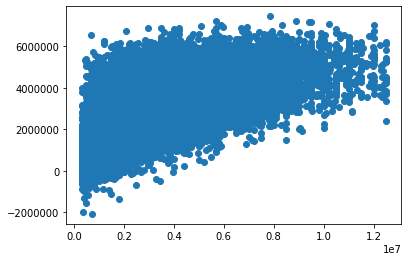

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Comparo predicciones con lo que de verdad es
plt.scatter(y_test, predictions)

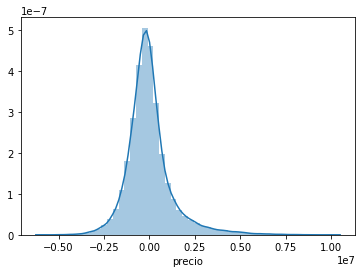

In [14]:
sns.distplot((y_test-predictions))
# Las diferencias entre las predicciones y la realidad son bastante distribuidas. 
# Tiende a haber muchos con diferencia cercana a 0

# Metricas

In [15]:
from sklearn import metrics
import numpy as np

def RMSLE(actual, pred):
    return (np.mean((np.log(actual + 1) - np.log(pred + 1)) ** 2)) **.5

# La razón para usar error logarítmico es que relativiza el error al valor absoluto considerado. Por ejemplo, consideremos un error absoluto de 1000 sobre un valor absoluto de 10 y uno de 100.000:

In [16]:
actual_1 = 10
actual_2 = 1000000
error = 1000

abs_error_1 = np.abs(actual_1 - (actual_1 + error))
abs_error_2 = np.abs(actual_2 - (actual_2 + error))

log_error_1 = np.abs(np.log(actual_1 + 1) - np.log(actual_1 + error + 1))
log_error_2 = np.abs(np.log(actual_2 + 1) - np.log(actual_2 + error + 1))

print(f"Error relativo grande - Abs: {abs_error_1:.4f}, Log:{log_error_1:.4f}")
print(f"Error relativo chico  - Abs: {abs_error_2:.4f}, Log:{log_error_2:.4f}")

Error relativo grande - Abs: 1000.0000, Log:4.5208
Error relativo chico  - Abs: 1000.0000, Log:0.0010


In [17]:
linear_rmsle = RMSLE(y_test, predictions)
linear_rmsle_train = RMSLE(y_train, lm.predict(X_train))
print(f"RMSLE Linear Regression (train): {linear_rmsle_train:.5f}")
print(f"RMSLE Linear Regression: {linear_rmsle:.5f}")

RMSLE Linear Regression (train): 0.58470
RMSLE Linear Regression: 0.59037


/home/ggparente95/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/ggparente95/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [18]:
#RMSE, sin logaritmo
np.sqrt(metrics.mean_squared_error(y_test, predictions))

1273502.3116883398

In [19]:
#Mean absolute error (el que importa para la competencia)
metrics.mean_absolute_error(y_test, predictions)

868788.2078244577